# Dependencies 

In [1]:
import numpy as np 
import pandas as pd

from dataset import Dataset
from interpolation import Interpolator 
from osmnx_to_pyg import osmnx_to_pyg 
from pyg_to_pygt import make_static_graph_temporal_signal
from utils import standardize, persistent_gps
from windows import random_pygt_circles, circle_graphs_from_points
from torch import nn, optim
from torch_geometric_temporal import DCRNN
from loss import RadMSELoss

# Overview
In this notebook, we will train a simple Recurrent Graph Neural Network to forecast pollution within a graph of New Delhi. 

# Data

In [2]:
weather = pd.read_csv(
    '../TF/data/delhi_weather_processed', 
    index_col='timestamp', 
    parse_dates=['timestamp'],
)
weather_scaler = standardize(
    weather, 
    ['Temperature', 'Pressure', 'Humidity', 'Wind Speed', 'Visibility', 'Dewpoint'],
)

pm_gps = pd.read_csv(
    '../TF/data/DAP_CPCB_all', 
    index_col='timestamp', 
    parse_dates=['timestamp'],
)
pm_gps_scaler = standardize(
    pm_gps, 
    ['pm2_5'],
)

In [45]:
GRAPH_RADIUS = 1000
BATCH_LENGTH = 200

dataset = Dataset(pm_gps=pm_gps, snapshot_minutes=15, weather=weather, minutes_to_weather=15)
batch = dataset[217]
graph_centers = persistent_gps(batch_gps=batch.gps)

subgraph_gen = circle_graphs_from_points(
    points=graph_centers, 
    radius=GRAPH_RADIUS,
)
next(subgraph_gen)
G = next(subgraph_gen)
pyg_data = osmnx_to_pyg(G=G)

interpolator = Interpolator(pyg_data.pos.numpy())
values = interpolator.interpolate_batch(
    pm_batch=batch.pm[:BATCH_LENGTH], 
    gps_batch=batch.gps[:BATCH_LENGTH],
)

dataset = make_static_graph_temporal_signal(
    pyg_data, values
)

# Model 

In [8]:
class RGNN(nn.Module):
    def __init__(self, node_features):
        super(RGNN, self).__init__()
        self.rec1 = DCRNN(node_features, 32, 1)
        self.rec2 = DCRNN(32, 16, 1)
        self.lin1 = nn.Linear(16, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.rec1(x, edge_index, edge_weight)
        h = self.rec2(h, edge_index, edge_weight)
        h = self.lin1(h)
        return h

# Example

In [25]:
import torch

from tqdm.notebook import tqdm
from torch_geometric_temporal.signal import temporal_signal_split 
from matplotlib import pyplot as plt

In [46]:
WINDOW_RADIUS = 1000
CENTER_RADIUS = 900
ROOT = 2 
N_WINDOWS = 10
N_EPOCHS = 20
RADIUS = 500
TRAIN_RATIO = 0.8

train_loss, valid_loss = [], []

device = 'cpu'
model = RGNN(node_features=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
labels_gps = torch.Tensor(list(graph_centers))

for epoch in tqdm(range(1, N_EPOCHS+1)):
    for window in random_pygt_circles(
        data=dataset, center_radius=CENTER_RADIUS, circle_radius=WINDOW_RADIUS, n=N_WINDOWS,
    ):
        # Set up RadMSELoss for each window individually, since the preds_gps will vary
        criterion = RadMSELoss(preds_gps=window[0].pos, labels_gps=labels_gps, 
                              radius=RADIUS)
        train_window, valid_window = temporal_signal_split(window, train_ratio=TRAIN_RATIO)
        
        # Training loop
        model.train()
        loss = 0
        for t, snapshot in enumerate(train_window):
            snapshot = snapshot.to(device)
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            loss += criterion(y_hat, snapshot.y)
        loss /= (t+1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())
        
        # Validation loop
        model.eval()
        loss = 0
        for t, snapshot in enumerate(valid_window):
            snapshot = snapshot.to(device)
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            loss += criterion(y_hat, snapshot.y)
        loss /= (t+1)
        valid_loss.append(loss.item())

  0%|          | 0/20 [00:00<?, ?it/s]

The loss for different windows behaves differently; thus, plotting the loss collected after each window gives us a rugged, although decreasing, graph.

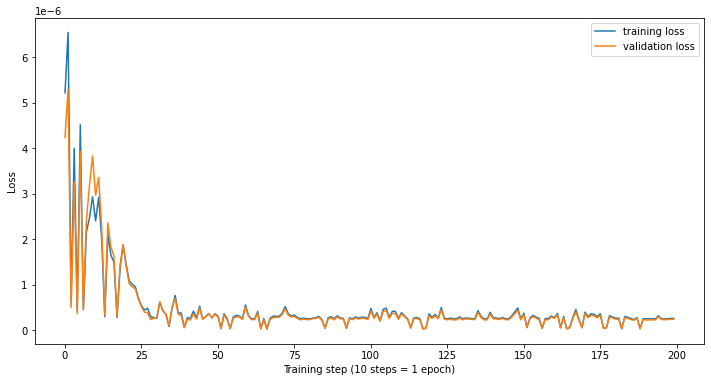

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_loss, label='training loss')
ax.plot(valid_loss, label='validation loss')
ax.set_ylabel("Loss")
ax.set_xlabel(f"Training step ({N_WINDOWS} steps = 1 epoch)")
ax.legend();

The graph of loss per epoch is still decreasing but smoother.

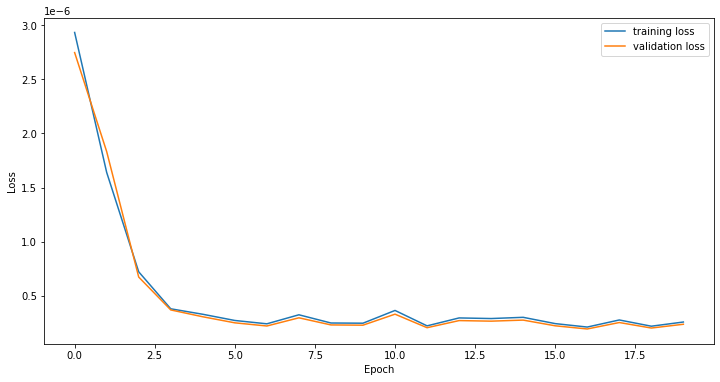

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))

train_loss_epoch = np.reshape(train_loss, (-1, N_WINDOWS)).mean(axis=-1)
valid_loss_epoch = np.reshape(valid_loss, (-1, N_WINDOWS)).mean(axis=-1)

ax.plot(train_loss_epoch, label='training loss')
ax.plot(valid_loss_epoch, label='validation loss')
ax.set_ylabel("Loss")
ax.set_xlabel(f"Epoch")
ax.legend();

We can also visualise the predicted graphs. 

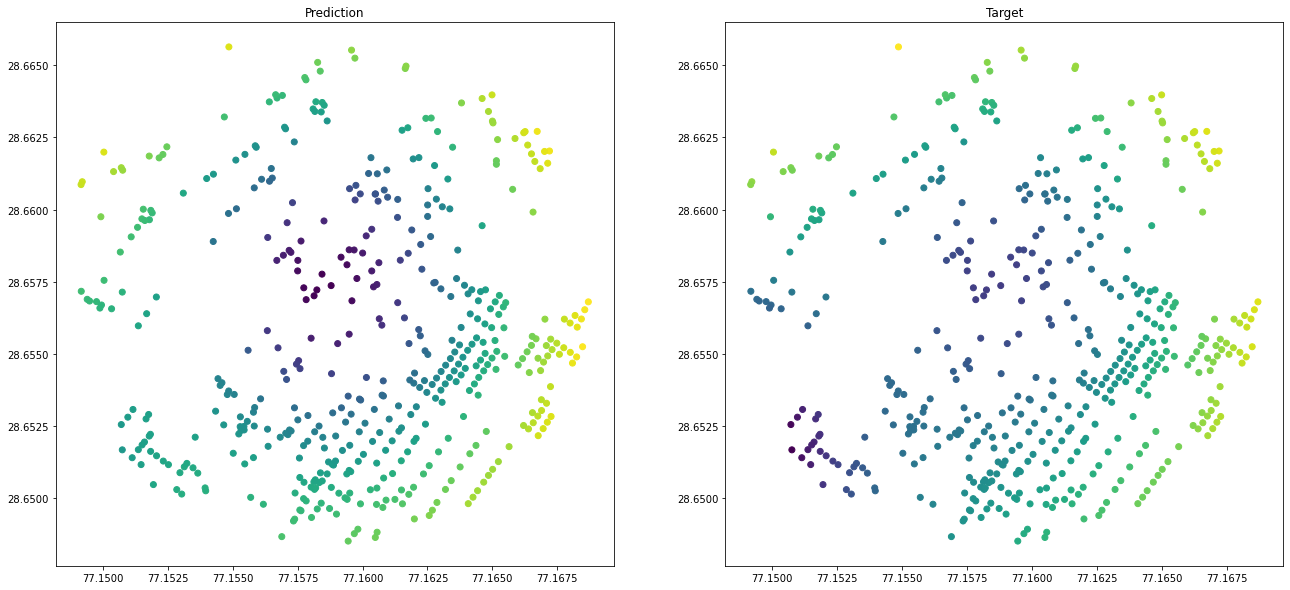

In [49]:
snapshot = dataset[0]
y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).detach()

fig, (ax_pred, ax_target) = plt.subplots(1, 2, figsize=(22, 10))
ax_pred.scatter(*snapshot.pos.T, c=y_hat)
ax_pred.set_title("Prediction")

ax_target.scatter(*snapshot.pos.T, c=snapshot.y)
ax_target.set_title("Target");